In [30]:
from tokeniser import Tokeniser
from load_text import load_prideandprejudice
import tensorflow as tf
import numpy as np
import sys
import os

# Create tokens

  0% (0 of 126) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 29% (37 of 126) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (98 of 126) |#################      | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (126 of 126) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Loading tokeniser from 'vocab.json'...


/home/jet/csoc420_assignment2/tokeniser.py:409: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


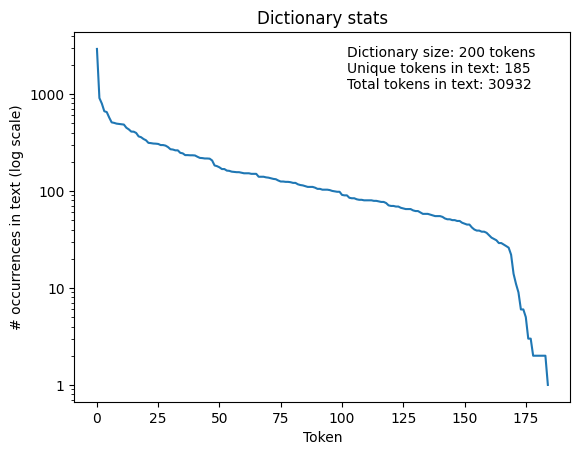

In [31]:
vocab_size = 1000 #Size of the vocabulary
filename = 'vocab.json'

# Load text
text = load_prideandprejudice(10000)

# Check if tokeniser has been saved to disk
if os.path.exists(filename):
    # Load tokeniser from disk
    print("Loading tokeniser from '%s'..." % (filename))
    tokeniser = Tokeniser.load(filename)
else:
    # Create a new tokeniser, train it on the text and save it to disk
    tokeniser = Tokeniser(vocab_size=vocab_size)
    print("Building BPE tokeniser...")
    tokeniser.train(text, verbose=True)
    print("Saving tokeniser to '%s'..." % (filename))
    tokeniser.save(filename)

ids = tokeniser.encode(text, verbose=True)
tokeniser.plot(ids=ids)


In [32]:
len(ids)

30932

# Util functions

In [33]:
def onehot_to_id(onehot):
    return onehot.argmax()

def id_to_onehot(i, vocab_size):
    onehot = np.zeros(vocab_size)
    onehot[i] = 1
    return onehot

def id_to_token(i):
    return tokeniser.decode([i])

def token_to_id(token):
    return tokeniser.encode(token)

def onehot_to_token(onehot):
    return id_to_token(onehot_to_id(onehot))

def sequence_to_tokens(sequence):
    return [onehot_to_token(i) for i in sequence]    

# CBOW

In [34]:
# single hidden layer NN
# num inputs = num tokens
# num outputs = num tokens

# num neurons in hidden layer = desired embedding size
# window size number of surrounding words to consider

# yn = middle word, yn-1 = previous word, yn+1 = next word
# use one hot encoding for yn-1 and yn+1
# one input is the one hot encoding of a word + the one hot encoding of the previous word (or sum of one hot encodings of surrounding words)
# no bias

# the output we want is the one hot encoding of the middle word

# train beginning with random weights
# output cant be perfect always, we just want some kind of embedding

# weghts of the matrix from input to hidden layer are the embeddings

### Create A dataset
y is the target token

x is a list of sequences. each sequence is the sum of the onehot encoding of the n tokens on either side of the y. where n is the window size

In [35]:
onehot = [id_to_onehot(i, vocab_size) for i in ids]
window_size = 4

if window_size % 2 != 0:
    raise ValueError("window_size must be even")

sequences = []
x = []
y = []

for i in range(window_size//2, len(ids) - window_size//2):
    sequence = np.array(onehot[i - window_size // 2:i] + onehot[i+1:i + window_size // 2 + 1])
    sequences.append(sequence)
    x.append(sum(sequence))
    y.append(onehot[i])

x = np.array(x)
y = np.array(y)

# train test val split
n = len(x)
n_train = int(0.8 * n)
n_test = int(0.1 * n)
n_val = n - n_train - n_test

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:n_train + n_test]
y_test = y[n_train:n_train + n_test]

x_val = x[n_train + n_test:]
y_val = y[n_train + n_test:]

### Define the embedding layer

In [36]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), 
            initializer='random_normal', 
            trainable=True)
        
    def get_embeddings(self):
        return self.w

    def call(self, inputs):
        return tf.nn.tanh(tf.matmul(inputs, self.w))

### Define and train the model
- input is a sequence
- output is a onehot encoded token
- we have one dense hidden layer with relu. the number of neurons is the number of dimensions of our vector embedding
- output layer with softmax. 

In [37]:
embedding_dimensions = 50 # mentioned 50-100 in skip gram paper

class tok2vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dimensions):
        super().__init__()
        self.embedding = Embedding(embedding_dimensions)
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def get_embeddings(self):
        return self.embedding.get_embeddings()

    def call(self, inputs):
        x = self.embedding(inputs)
        return self.dense(x)

model = tok2vec(vocab_size, embedding_dimensions)

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(embedding_dimensions, activation='tanh'),
#     tf.keras.layers.Dense(vocab_size, activation='softmax')
# ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_info = model.fit(x_train, y_train, 
                       validation_data=(x_val, y_val),
                       epochs=10,
                       shuffle=True,
                       verbose=1)
model.summary()

Epoch 1/10
774/774 [==============================] - 2s 2ms/step - loss: 4.8448 - accuracy: 0.0941 - val_loss: 4.4371 - val_accuracy: 0.0963
Epoch 2/10
774/774 [==============================] - 1s 1ms/step - loss: 4.1950 - accuracy: 0.1491 - val_loss: 4.1084 - val_accuracy: 0.1458
Epoch 3/10
774/774 [==============================] - 1s 2ms/step - loss: 3.8442 - accuracy: 0.1964 - val_loss: 3.8094 - val_accuracy: 0.2020
Epoch 4/10
774/774 [==============================] - 1s 1ms/step - loss: 3.5309 - accuracy: 0.2434 - val_loss: 3.6005 - val_accuracy: 0.2262
Epoch 5/10
774/774 [==============================] - 1s 2ms/step - loss: 3.3010 - accuracy: 0.2755 - val_loss: 3.4597 - val_accuracy: 0.2437
Epoch 6/10
774/774 [==============================] - 2s 2ms/step - loss: 3.1358 - accuracy: 0.3008 - val_loss: 3.3700 - val_accuracy: 0.2557
Epoch 7/10
774/774 [==============================] - 1s 2ms/step - loss: 3.0142 - accuracy: 0.3212 - val_loss: 3.3081 - val_accuracy: 0.2663
Epoch 

### Get Embeddings and save them to file

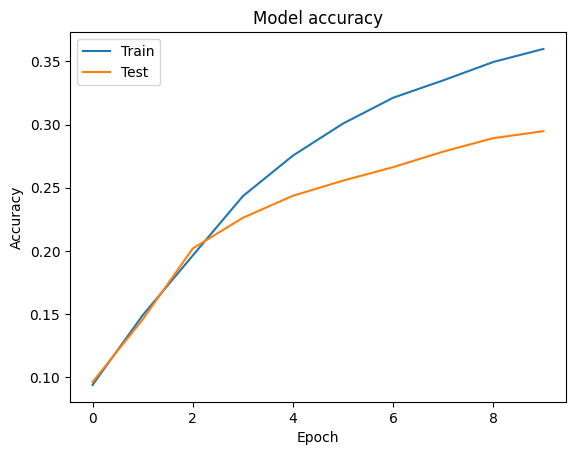

In [38]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(train_info.history['accuracy'])
plt.plot(train_info.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

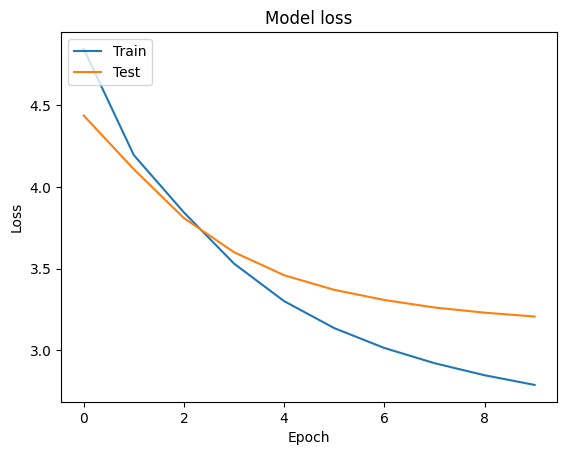

In [39]:
# plot loss
plt.plot(train_info.history['loss'])
plt.plot(train_info.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
def plot_tok2vec(w, word_index, num_words_to_show=100, show_word_tokens=[]):
    '''
    Plot the word vectors in 2D using t-SNE.  This method is dependent on nltk library (to select words to show).
    You can install the library with 'pip install nltk'
    
    param w: word vectors, numpy array of shape (vocab_size, vec_dim)
    param word_index: tokeniser word_index, a python dictionary that maps vocab_size words to integer ids
    param num_words_to_show: number of words to show in the plot (default 100)
    param show_word_tokens: list of tokens to show in the plot, if empty, the method will select up to 100 English words from the dictionary

    '''
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    if len(show_word_tokens)==0:
        try:
            import nltk
        except:
            raise RuntimeError("Error: nltk is not installed. Please install nltk using 'pip install nltk'")

        # Select up to 100 words from the tokens that are in the words dictionary
        try:
            nltk.data.find('corpora/words')
        except LookupError:
            nltk.download('words')

        english_dictionary = nltk.corpus.words.words()
        vocab_size = len(word_index)
        show_word_tokens = []
        words = list(word_index.keys())
        for i in range(vocab_size):
            word = words[i]
            if word[0] == ' ':
                if len(word) > 4 and word[1:] in english_dictionary:
                    show_word_tokens  += [i]
            else:
                if len(word) > 3 and word in english_dictionary:
                    show_word_tokens  += [i]

            if len(show_word_tokens) >= num_words_to_show:
                break

    # Convert the tokens to vectors
    x = w[show_word_tokens]
    print(x.shape[0])

    # Do dimension reduction from vec_dim to 2 (so we can plot the word points in 2D)
    tsne = TSNE(n_components=2, random_state=0)
    x_2d = tsne.fit_transform(x)

    # Plot vectors showing the first 100 tokens with text close to the point corresponding to the token
    plt.figure(figsize=(6, 5))
    for i in range(len(show_word_tokens)):
        plt.scatter(x_2d[i,0], x_2d[i,1],c='b')
        word = words[show_word_tokens[i]]
        plt.text(x_2d[i,0], x_2d[i,1], word, fontsize=9)
    plt.show()

In [41]:
w = model.get_embeddings().numpy()
w.shape


(1000, 50)

In [43]:
plot_tok2vec(w, tokeniser.word_index)

4


ValueError: perplexity must be less than n_samples